# Project Beauty-Fashion-Mobile Classifier

There are hundreds of thousands new products added to Shopee every day. To make relevant products easily discoverable, one fundamental challenge is to accurately extract relevant information from a large volume of products. For the National Data Science Challenge (NDSC) 2019 , the challenge presented this real-world challenge of building an automatic solution to extract product related information through machine learning techniques.

There are 3 broad categories of products for classification:
1. Beauty
2. Fashion
3. Mobile

One of the biggest challenges in product identification and classification is largely due to sellers posting unclear images such as screenshots of their posts, taking pictures at different angles and taking pictures mixed with other product categories. While we can depend on sellers to write up their post on the products that they are selling, a classification algorithm that separates product types into its broad categories will allow us to segment product types more accurately so that customers can search for their items in a more efficient manner.

In [ ]:
!nvidia-smi

Fri Aug 20 03:27:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Sharable Link for Colab Notebook

https://colab.research.google.com/drive/1gF0T1agm4bSAi0xBk4atscqGSHoDMkJP?usp=sharing

# Import Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, json
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

import tensorflow as tf

import glob
import pandas as pd
import os

# Load Data

The folder size for three product categories, are as follow: the beauty images (22GB tar file), fashion images (35.2GB tar file), and mobile images (10.4GB tar file) accordingly. This translates to over 67GB of data and would not be computationally possible based on Colab's GPU Ram to load in all the data for training.

As such, the data was sampled randomly with approximately 1100 to 1200 images per class for training and validation and another 3 separate images ranging from easy to hard in classification difficulty was used per class for testing.



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
data = []

main_path = "/content/drive/MyDrive/Colab Notebooks"
folders = ["main_beauty_1000_img", "main_fashion_1000_img", "main_mobile_1000_img"]

# Loading data from path
for folder in folders:
    for _file in os.listdir(f'{main_path}/{folder}'):
        filepath = f'{main_path}/{folder}/{_file}'
        class_name = f'{folder.split("_")[1]}'
        data.append((filepath, class_name))

# Writing to dataframe
df = pd.DataFrame(data, columns=['filepath', 'class_name'])

# Coercing into categorical data type
df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# Check basic statistics of dataframe
print(df.head())
print(len(df))
df.dtypes

                                            filepath class_name  class
0  /content/drive/MyDrive/Colab Notebooks/main_fa...    fashion      1
1  /content/drive/MyDrive/Colab Notebooks/main_fa...    fashion      1
2  /content/drive/MyDrive/Colab Notebooks/main_fa...    fashion      1
3  /content/drive/MyDrive/Colab Notebooks/main_fa...    fashion      1
4  /content/drive/MyDrive/Colab Notebooks/main_mo...     mobile      2
3538


filepath        object
class_name    category
class             int8
dtype: object

## Types of Images

In [ ]:
def plot_training_image(img_path, img_class):

    class_map = {0:"beauty",
                1:"fashion",
                2:"mobile"}

    print("Product Type:", class_map[img_class])
    print("Product Class", img_class)
    print()
    print()

    img = plt.imread(f'{img_path}')
    plt.imshow(img)


### Beauty

Product Type: beauty
Product Class 0




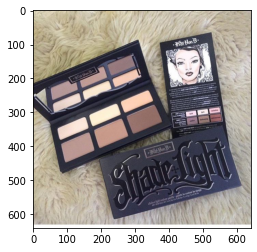

In [ ]:
plot_training_image(df['filepath'][5], df['class'][5])

### Fashion

Product Type: fashion
Product Class 1




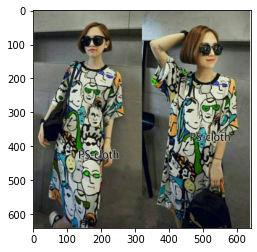

In [ ]:
plot_training_image(df['filepath'][0], df['class'][0])

### Mobile

Product Type: mobile
Product Class 2




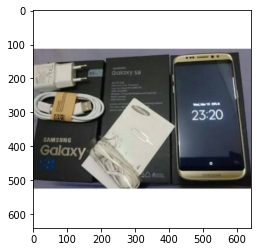

In [ ]:
plot_training_image(df['filepath'][4], df['class'][4])

# Train-Validation Data Split

The training data was splited into training and validation dataset with `90%` of the data for training and `10%` of the data for validation. To ensure that data is fed at random into the model, the datasets for training and validation were shuffled again after splitting.

**Table for Reference:**

No. of images for training | No. of images for validation | No. of images for testing
--- | --- | ---
3184 images | 354 images | 9 images



In [ ]:
# Split into train and validation sets
train_set_percentage = .9


df_train = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

# Image Preprocessing

As images are of different sizes, they were resized to fit the dimension of 224 by 224 pixel in width and length with 3 channels (RGB). As the dataset is relatively small, the batch size was set at 32 images per batch to prevent the event of poor generalization.

In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224
num_classes = 3
batch_size = 32

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3) # tf.image.decode_png
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filepath'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(500)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filepath'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

# Loading Pre-trained model

Resnet50 is used as it is a relatively easy model to train on once the base model layers are frozen and its architecture provides sufficient complexity to function as a relatively good classification model.

In [ ]:
# create the base pre-trained model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Stitching on Classification Layer

In [ ]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# Stitch on a fully connected layer
x = Dense(512, activation='relu', name='DenseFC_01')(x)
x = Dropout(0.3)(x)

# and a logits layer 
predictions = Dense(3, activation='softmax')(x)

# Assembling the model

In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional resnet50 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False
    print(layer.name,' Trainable =',layer.trainable)


input_2
input_2  Trainable = False
conv1_pad
conv1_pad  Trainable = False
conv1_conv
conv1_conv  Trainable = False
conv1_bn
conv1_bn  Trainable = False
conv1_relu
conv1_relu  Trainable = False
pool1_pad
pool1_pad  Trainable = False
pool1_pool
pool1_pool  Trainable = False
conv2_block1_1_conv
conv2_block1_1_conv  Trainable = False
conv2_block1_1_bn
conv2_block1_1_bn  Trainable = False
conv2_block1_1_relu
conv2_block1_1_relu  Trainable = False
conv2_block1_2_conv
conv2_block1_2_conv  Trainable = False
conv2_block1_2_bn
conv2_block1_2_bn  Trainable = False
conv2_block1_2_relu
conv2_block1_2_relu  Trainable = False
conv2_block1_0_conv
conv2_block1_0_conv  Trainable = False
conv2_block1_3_conv
conv2_block1_3_conv  Trainable = False
conv2_block1_0_bn
conv2_block1_0_bn  Trainable = False
conv2_block1_3_bn
conv2_block1_3_bn  Trainable = False
conv2_block1_add
conv2_block1_add  Trainable = False
conv2_block1_out
conv2_block1_out  Trainable = False
conv2_block2_1_conv
conv2_block2_1_conv  Traina

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0008, epsilon=0.1) # initial 0.001 learning_rate

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Setting hyperparameters

In [ ]:
# Checking data shape for training and validation dataset
df_train.shape, df_val.shape

((3184, 3), (354, 3))

In [ ]:
# Setting training and validation steps per epoch
train_steps = int(3184/32) #total trains set / batch_size
val_steps = int(354/32)

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 99
val steps: 11


# Data Augmentation & Training

As I was unable to use all the data for training, it is likely that the model might miss out certain types of images hence, data augmentation was used to provide some variation to the images that were fed into the model for training. As sellers are likely to take images from different angles, a key part to data augmentation would to include some rotation to the images that was fed into the model. This is illustrated in one of the testing images for mobile products where the seller took a slanted picture of the product.

For a more efficient model training process, an early stopping mechanism was put in place so that the model will terminate its training process if validation accuracy stops improving after `8 epochs` from the last best checkpointed model. At every point where validation accuracy increases, the model is checkpointed and the new model (that produces a better validation accuracy score) is saved to a `hdf5` file together with its corresponding trained weights. This is also done to prevent an overfitted model that does not generalize to well.

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(width_shift_range=0.1,        # shift the image left / right by 10%
                                    height_shift_range=0.1,      # shift the image up / down by 10%
                                    rotation_range=20,           # rotate image l/r by 20 degree
                                    horizontal_flip=True)

test_datagen = ImageDataGenerator()

# Store the history & set early stopping
history = History()
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   verbose=1, 
                   patience=8)  # Training will wait 8 epochs to check for any improvement to validation accuracy

# Save best model to train epoch
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/resnet50_v2.hdf5', 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True, 
                             mode='max');  

callbacks = [es, checkpoint, history]

model.fit(train_dataset, 
          steps_per_epoch = train_steps,
          epochs = 100,
          validation_data = valid_dataset,
          validation_steps = val_steps,
          callbacks = callbacks)

Epoch 1/100
99/99 [==============================] - 1271s 11s/step - loss: 0.6447 - accuracy: 0.7251 - val_loss: 0.2314 - val_accuracy: 0.9290

Epoch 00001: val_accuracy improved from -inf to 0.92898, saving model to /content/drive/MyDrive/Colab Notebooks/resnet50_v2.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
99/99 [==============================] - 34s 347ms/step - loss: 0.2268 - accuracy: 0.9173 - val_loss: 0.1602 - val_accuracy: 0.9347

Epoch 00002: val_accuracy improved from 0.92898 to 0.93466, saving model to /content/drive/MyDrive/Colab Notebooks/resnet50_v2.hdf5
Epoch 3/100
99/99 [==============================] - 34s 346ms/step - loss: 0.1703 - accuracy: 0.9372 - val_loss: 0.1402 - val_accuracy: 0.9347

Epoch 00003: val_accuracy did not improve from 0.93466
Epoch 4/100
99/99 [==============================] - 34s 348ms/step - loss: 0.1446 - accuracy: 0.9489 - val_loss: 0.1276 - val_accuracy: 0.9489

Epoch 00004: val_accuracy improved from 0.93466 to 0.94886, saving model to /content/drive/MyDrive/Colab Notebooks/resnet50_v2.hdf5
Epoch 5/100
99/99 [==============================] - 35s 352ms/step - loss: 0.1271 - accuracy: 0.9545 - val_loss: 0.1134 - val_accuracy: 0.9545

Epoch 00005: val_accuracy improved from 0.94886 to 0.95455, saving model to /content/drive/MyDrive/Co

# Plot Training and Validation Metrics

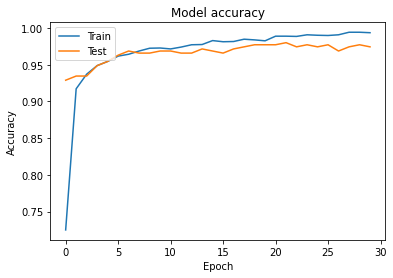

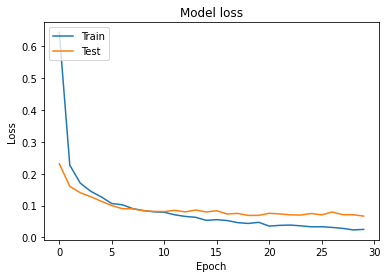

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Loading Best Model

In [ ]:
best_model = load_model("/content/drive/MyDrive/Colab Notebooks/resnet50_v2.hdf5")

## Compile Model

In [ ]:
# Compile model
print("Compiling model....")
opt = tf.keras.optimizers.Adam(epsilon=1) # Set epsilon to 1 as no training is required for prediction

best_model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("Model Compiled!")

Compiling model....
Model Compiled!


## Test on Images

Images are selected on a scale ranging from easy to hard in 3 stages. 

### **Difficulty: Easy**

Easy images are usually images that are straightforward where the image of the product is clear and not blocked by any other elements. 

### **Difficulty: Medium**

Images that are of slightly more difficult to classify and belong to the medium difficulty group are images that are slightly covered and blocked by elements such as having another product item in the same image. 

### **Difficulty: Hard**
Images that are of hard to classify are deemed as images that are taken from a random Google image that is related to the product category and have other products and noise in it. These images are to test whether the model can accurately classify the intent of the image.

Based on the model trained, it seems like the model can accurately classify all the images regardless of difficulty and can do so with relatively high confidence.

### Beauty Dataset Test

In [ ]:
def plot_image(img_path, model, difficulty_class, ground_truth):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    class_map = {0:"beauty",
                1:"fashion",
                2:"mobile"}

    print(f"Difficulty: {difficulty_class}")
    print(f'Predicted Class: {class_map[np.argmax(preds)]}')
    print(f'Ground Truth Class:', ground_truth)
    print()
    print()

    img = plt.imread(f'{img_path}')
    plt.imshow(img)


Difficulty: Easy
Predicted Class: beauty
Ground Truth Class: beauty




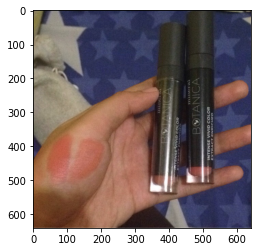

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks'
beauty_images_check = ['beauty_easy.jpg', 'beauty_medium.jpg', 'beauty_hard.jpg']
img_path = f'{image_path}/{beauty_images_check[0]}'
plot_image(img_path,best_model, "Easy", "beauty")

Difficulty: Medium
Predicted Class: beauty
Ground Truth Class: beauty




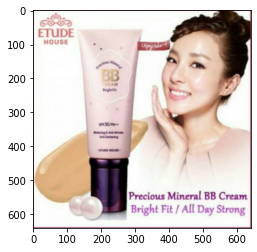

In [ ]:
img_path = f'{image_path}/{beauty_images_check[1]}'
plot_image(img_path,best_model, "Medium", "beauty")

Difficulty: Hard
Predicted Class: beauty
Ground Truth Class: beauty




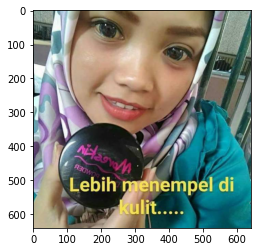

In [ ]:
img_path = f'{image_path}/{beauty_images_check[2]}'
plot_image(img_path,best_model, "Hard", "beauty")

### Fashion Dataset Test

Difficulty: Easy
Predicted Class: fashion
Ground Truth Class: fashion




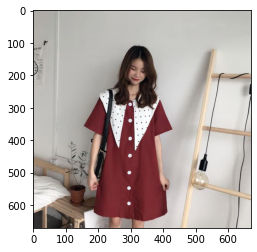

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks'
fashion_images_check = ['fashion_easy.jpg', 'fashion_medium.jpg', 'fashion_hard.jpg']
img_path = f'{image_path}/{fashion_images_check[0]}'
plot_image(img_path,best_model, "Easy", "fashion")

Difficulty: Medium
Predicted Class: fashion
Ground Truth Class: fashion




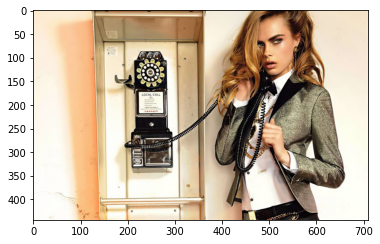

In [ ]:
img_path = f'{image_path}/{fashion_images_check[1]}'
plot_image(img_path,best_model, "Medium", "fashion")

Difficulty: Hard
Predicted Class: fashion
Ground Truth Class: fashion




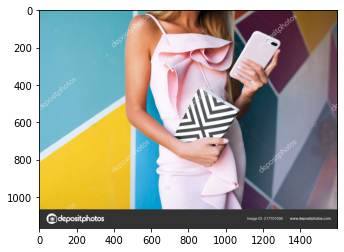

In [ ]:
img_path = f'{image_path}/{fashion_images_check[2]}'
plot_image(img_path,best_model, "Hard", "fashion")

### Mobile Dataset Test

Difficulty: Easy
Predicted Class: mobile
Ground Truth Class: mobile




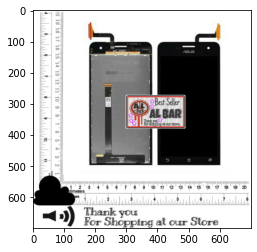

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks'
mobile_images_check = ['mobile_easy.jpg', 'mobile_medium.jpg', 'mobile_hard.jpg']
img_path = f'{image_path}/{mobile_images_check[0]}'
plot_image(img_path,best_model, "Easy", "mobile")

Difficulty: Medium
Predicted Class: mobile
Ground Truth Class: mobile




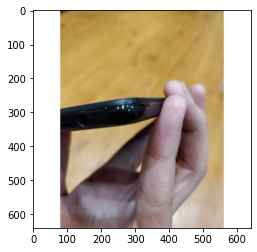

In [ ]:
img_path = f'{image_path}/{mobile_images_check[1]}'
plot_image(img_path,best_model, "Medium", "mobile")

Difficulty: Hard
Predicted Class: mobile
Ground Truth Class: mobile




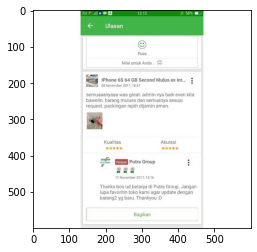

In [ ]:
img_path = f'{image_path}/{mobile_images_check[2]}'
plot_image(img_path,best_model, "Hard",  "mobile")

# Reflections

Through this project, I learnt about transfer learning and how to train a model effectively through techniques such as freezing of layers before the classification layer and only train the model subsequently. I also learnt about how to implement early stopping mechanism that helps the us save time from waiting endlessly in front of the computer to observe the model's performance. 

I have also learnt that data preparation is the one of the most important component of all and is one of the most challenging parts for me. However, thanks to the guidance from Sam's and Martin's notebooks, I was able to obtain the necessary codes to perform the task of loading in the data in an easy and efficient manner which was very helpful!